In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

@author = Steve Walker

<div style="display: flex; align-items: left;">
    <a href="https://sites.google.com/corp/google.com/genai-solutions/home?authuser=0">
        <img src="https://storage.googleapis.com/miscfilespublic/Linkedin%20Banner%20%E2%80%93%202.png" style="margin-right">
    </a>
</div>

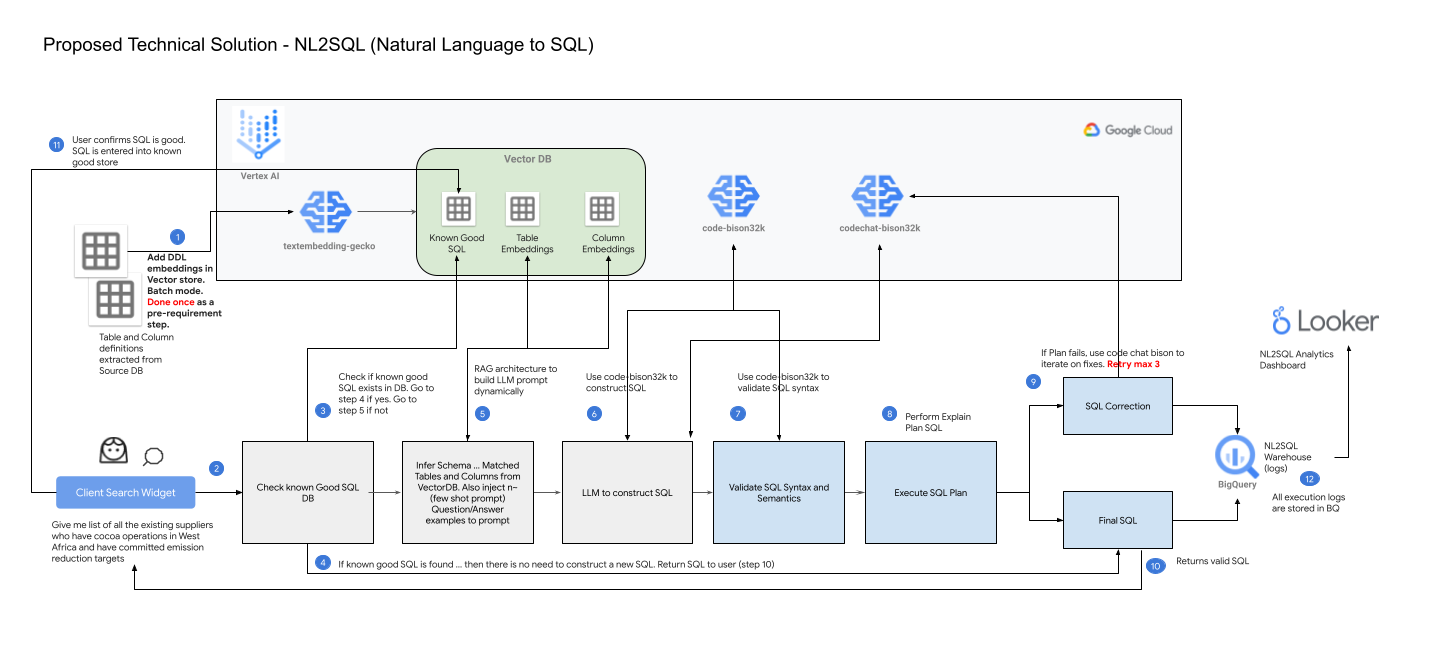

# **Installing all the required dependencies**



In [2]:
first = True
if first:
  ! pip install google-cloud-aiplatform --upgrade
  ! pip install shapely==1.8.5
  ! pip install sqlalchemy --upgrade
  ! pip install asyncio asyncpg cloud-sql-python-connector["asyncpg"]
  ! pip install numpy pandas
  ! pip install pgvector
  ! pip install pg8000
  ! pip install gradio


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached Shapely-1.8.5.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/Users/msubasioglu/Desktop/Code/NL2SQL/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/msubasioglu/Desktop/Code/NL2SQL/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/msubasioglu/Desktop/Code/NL2SQL/.venv/lib/python3.12/site-packages/

In [ ]:
# get_ipython().kernel.do_shutdown(True)

# Common Variables

In [4]:
! gcloud auth login


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=dR4SJTEBMFUSKgXjVvDc3aemFdttc1&access_type=offline&code_challenge=8gmSrjasQu8xKcSiWgRGMk9eQt5tRQCULIypqW5Izxs&code_challenge_method=S256


You are now logged in as [msubasioglu@google.com].
Your current project is [future-backoffice-hr-assistant].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud component

In [ ]:

source_type='BigQuery'


# @markdown Provide the below details to start using the notebook
PROJECT_ID='steveswalker-sandbox' # @param {type:"string"}
REGION = 'us-central1' # @param {type:"string"}
DATAPROJECT_ID='steveswalker-sandbox'  # This needs to be adjusted when using the bq public dataset

#set and show gcp project
!gcloud config set project {PROJECT_ID}
!gcloud config get-value project
#!bash gcloud auth application-default login


# BQ Schema (DATASET) where tables leave
schema='imdb' # @param {type:"string"}.  ### DDL extraction performed at this level, for the entire schema
USER_DATASET= DATAPROJECT_ID + '.' + schema

# Execution Parameters
SQL_VALIDATION='ALL'
INJECT_ONE_ERROR=False
EXECUTE_FINAL_SQL=True
SQL_MAX_FIX_RETRY=3
AUTO_ADD_KNOWNGOOD_SQL=True

# Analytics Warehouse
ENABLE_ANALYTICS=True
DATASET_NAME='nl2sql'
DATASET_LOCATION='US'
LOG_TABLE_NAME='query_logs'
FULL_LOG_TEXT=''


# Palm Models to use
model_id='gemini-pro' # @param {type:"string"}
chat_model_id='codechat-bison-32k' # @param {type:"string"}
embeddings_model='textembedding-gecko@001'


# PGVECTOR (Cloud SQL Postgres) Info.
database_password = "hr_tutorial"  # @param {type:"string"}
instance_name = "pg15-nl2sql-pgvector"  # @param {type:"string"}
database_name = "nl2sql-admin"  # @param {type:"string"}
database_user = "nl2sql-admin"  # @param {type:"string"}
num_table_matches = 5
num_column_matches = 20
similarity_threshold = 0.1
num_sql_matches=3

# @markdown Create an HNSW index
m =  24 # @param {type:"integer"}
ef_construction = 100  # @param {type:"integer"}
operator =  "vector_cosine_ops"  # @param ["vector_cosine_ops", "vector_l2_ops", "vector_ip_ops"]



Updated property [core/project].
steveswalker-sandbox


# Common Imports Section

In [ ]:
# Common Imports
import time
import datetime
from datetime import datetime, timezone
import hashlib
import vertexai
import pandas
import pandas_gbq
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import text
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()
import json
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
from logging import exception
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector
from google.cloud import aiplatform
from vertexai.language_models import TextEmbeddingModel
import gradio as gr



# Initialize Palm Models to be used

In [ ]:

def createModel(PROJECT_ID, REGION, model_id):
  from vertexai.preview.language_models import TextGenerationModel
  from vertexai.preview.language_models import CodeGenerationModel
  from vertexai.preview.language_models import CodeChatModel
  from vertexai.preview.generative_models import GenerativeModel

  if model_id == 'code-bison-32k':
    model = CodeGenerationModel.from_pretrained('code-bison-32k')
  elif model_id == 'text-bison-32k':
    model = TextGenerationModel.from_pretrained('text-bison-32k')
  elif model_id == 'codechat-bison-32k':
    model = CodeChatModel.from_pretrained("codechat-bison-32k")
  elif model_id == 'gemini-pro':
    model = GenerativeModel("gemini-pro")
  else:
    raise ValueError
  return model


vertexai.init(project=PROJECT_ID, location=REGION)
model=createModel(PROJECT_ID, REGION,model_id)
chat_model=createModel(PROJECT_ID, REGION,chat_model_id)

# Metadata embedding

## Define BigQuery Dictionary Queries and Helper Functions

In [ ]:

get_columns_sql=f'''
SELECT
    TABLE_CATALOG as project_id, TABLE_SCHEMA as owner , TABLE_NAME as table_name, COLUMN_NAME as column_name,
    DATA_TYPE as data_type, ROUNDING_MODE as rounding_mode, description
  FROM
    {USER_DATASET}.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
  ORDER BY
   project_id, owner, table_name, column_name ;
'''

# f'''
#  SELECT
#     TABLE_CATALOG as project_id, TABLE_SCHEMA as owner , TABLE_NAME as table_name, COLUMN_NAME as column_name,
#     IS_NULLABLE as is_nullable, DATA_TYPE as data_type, COLUMN_DEFAULT as column_default, ROUNDING_MODE as rounding_mode
#   FROM
#     {USER_DATASET}.INFORMATION_SCHEMA.COLUMNS
#   ORDER BY
#    project_id, owner, table_name, column_name ;
# '''


get_fkeys_sql=f'''
SELECT T.CONSTRAINT_CATALOG, T.CONSTRAINT_SCHEMA, T.CONSTRAINT_NAME,
T.TABLE_CATALOG as project_id, T.TABLE_SCHEMA as owner, T.TABLE_NAME as table_name, T.CONSTRAINT_TYPE,
T.IS_DEFERRABLE, T.ENFORCED, K.COLUMN_NAME
FROM
{USER_DATASET}.INFORMATION_SCHEMA.TABLE_CONSTRAINTS T
JOIN {USER_DATASET}.INFORMATION_SCHEMA.KEY_COLUMN_USAGE K
ON K.CONSTRAINT_NAME=T.CONSTRAINT_NAME
WHERE
T.CONSTRAINT_TYPE="FOREIGN KEY"
ORDER BY
project_id, owner, table_name
'''

get_pkeys_sql=f'''
SELECT T.CONSTRAINT_CATALOG, T.CONSTRAINT_SCHEMA, T.CONSTRAINT_NAME,
T.TABLE_CATALOG as project_id, T.TABLE_SCHEMA as owner, T.TABLE_NAME as table_name, T.CONSTRAINT_TYPE,
T.IS_DEFERRABLE, T.ENFORCED, K.COLUMN_NAME
FROM
{USER_DATASET}.INFORMATION_SCHEMA.TABLE_CONSTRAINTS T
JOIN {USER_DATASET}.INFORMATION_SCHEMA.KEY_COLUMN_USAGE K
ON K.CONSTRAINT_NAME=T.CONSTRAINT_NAME
WHERE
T.CONSTRAINT_TYPE="PRIMARY KEY"
ORDER BY
project_id, owner, table_name
'''


get_table_comments_sql=f'''
select TABLE_CATALOG as project_id, TABLE_SCHEMA as owner , TABLE_NAME as table_name, OPTION_NAME, OPTION_TYPE, OPTION_VALUE as comments
FROM
{USER_DATASET}.INFORMATION_SCHEMA.TABLE_OPTIONS
WHERE
 OPTION_NAME = "description"
ORDER BY
project_id, owner, table_name
'''



def schema_generator(sql):
  df = pandas_gbq.read_gbq(sql, project_id=PROJECT_ID)
  return df


def add_table_comments(columns_df, pkeys_df, fkeys_df, table_comments_df):

  for index, row in table_comments_df.iterrows():
    if row['comments'] is None: ## or row['comments'] is not None:
        context_prompt = f"""
        Generate table comments for the table {row['project_id']}.{row['owner']}.{row['table_name']}

        Parameters:
        - column metadata: {columns_df.to_markdown(index = False)}
        - primary key metadata: {pkeys_df.to_markdown(index = False)}
        - foreign keys metadata: {fkeys_df.to_markdown(index = False)}
        - table metadata: {table_comments_df.to_markdown(index = False)}
      """
        #context_query = model.predict(context_prompt, max_output_tokens = 256, temperature= 0.2)
        context_query = model.generate_content(context_prompt, stream=False)
        print(clean_sql(str(context_query.candidates[0])))
        table_comments_df.at[index, 'comments'] = clean_sql(str(context_query.candidates[0]))

  return table_comments_df


def add_column_comments(columns_df, pkeys_df, fkeys_df, table_comments_df):
  for index, row in columns_df.iterrows():
        context_prompt = f"""
        Generate comments for the column {row['project_id']}.{row['owner']}.{row['table_name']}.{row['column_name']}


        Parameters:
        - column metadata: {columns_df.to_markdown(index = False)}
        - primary key metadata: {pkeys_df.to_markdown(index = False)}
        - foreign keys metadata: {fkeys_df.to_markdown(index = False)}
        - table metadata: {table_comments_df.to_markdown(index = False)}

      """
        #context_query = model.generate_content(context_prompt, stream=False)
        #columns_df.at[index, 'column_comments'] = clean_sql(str(context_query.candidates[0]))
        columns_df.at[index, 'column_comments'] = clean_sql("my comments")

  return columns_df

def get_column_sample(columns_df):
  sample_column_list=[]

  for index, row in columns_df.iterrows():
    get_column_sample_sql=f'''
        SELECT STRING_AGG(CAST(value AS STRING)) as sample_values
        FROM UNNEST((SELECT APPROX_TOP_COUNT({row["column_name"]}, 5) as osn
                     FROM `{row["project_id"]}.{row["owner"]}.{row["table_name"]}`
                ))
    '''
    column_samples_df=schema_generator(get_column_sample_sql)
    sample_column_list.append(column_samples_df['sample_values'].to_string(index=False))

  columns_df["sample_values"]=sample_column_list
  return columns_df



def clean_sql(result):
  result = result.replace("```sql", "").replace("```", "")
  return result




## Store the table, column definition, primary/foreign keys and comments into Dataframes

In [ ]:

columns_df=schema_generator(get_columns_sql)
fkeys_df=schema_generator(get_fkeys_sql)
pkeys_df=schema_generator(get_pkeys_sql)
table_comments_df=schema_generator(get_table_comments_sql)



Downloading: 100%|██████████|
Downloading: |          |
Downloading: |          |
Downloading: 100%|██████████|


## Displaying the Dataframes

In [ ]:
data_table.DataTable(fkeys_df)

,CONSTRAINT_CATALOG,CONSTRAINT_SCHEMA,CONSTRAINT_NAME,project_id,owner,table_name,CONSTRAINT_TYPE,IS_DEFERRABLE,ENFORCED,COLUMN_NAME


In [ ]:
data_table.DataTable(pkeys_df)

,CONSTRAINT_CATALOG,CONSTRAINT_SCHEMA,CONSTRAINT_NAME,project_id,owner,table_name,CONSTRAINT_TYPE,IS_DEFERRABLE,ENFORCED,COLUMN_NAME


In [ ]:
data_table.DataTable(columns_df)

,project_id,owner,table_name,column_name,data_type,rounding_mode,description
0,steveswalker-sandbox,imdb,name_basics,birth_year,INT64,None,Birth year in YYYY format.
1,steveswalker-sandbox,imdb,name_basics,death_year,INT64,None,Death year in YYYY format if applicable.
2,steveswalker-sandbox,imdb,name_basics,known_for_titles,STRING,None,Titles the person is known for.
3,steveswalker-sandbox,imdb,name_basics,nconst,STRING,None,Alphanumeric unique identifier of the name/per...
4,steveswalker-sandbox,imdb,name_basics,primary_name,STRING,None,Name by which the person is most often credited.
5,steveswalker-sandbox,imdb,name_basics,primary_profession,STRING,None,The top-3 professions of the person.
6,steveswalker-sandbox,imdb,reviews,label,STRING,None,"It has three categories Negative, Positive and..."
7,steveswalker-sandbox,imdb,reviews,movie_id,STRING,None,UniqueId for the movie in IMDb.
8,steveswalker-sandbox,imdb,reviews,movie_url,STRING,None,Movie url for corresponding movie_id
9,steveswalker-sandbox,imdb,reviews,review,STRING,None,User review's in IMDb.


In [ ]:
data_table.DataTable(table_comments_df)

,project_id,owner,table_name,OPTION_NAME,OPTION_TYPE,comments
0,steveswalker-sandbox,imdb,name_basics,description,STRING,"""Contains the actor, director or people inform..."
1,steveswalker-sandbox,imdb,reviews,description,STRING,"""Contains the people review related details ca..."
2,steveswalker-sandbox,imdb,title_akas,description,STRING,"""Contains the alternate or original title of e..."
3,steveswalker-sandbox,imdb,title_basics,description,STRING,"""Contains the move description details such as..."
4,steveswalker-sandbox,imdb,title_crew,description,STRING,"""Contains the crew level information for each ..."
5,steveswalker-sandbox,imdb,title_episode,description,STRING,"""Contains the information related to the serie..."
6,steveswalker-sandbox,imdb,title_principals,description,STRING,"""Contains the crew details for the give move/s..."
7,steveswalker-sandbox,imdb,title_ratings,description,STRING,"""Contains the information related to the move/..."


## Adding column sample_values to the columns dataframe
This is done by concatenating 3 values with each value separated by ;

In [ ]:

columns_df=get_column_sample(columns_df)
data_table.DataTable(columns_df)



Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloadin

,project_id,owner,table_name,column_name,data_type,rounding_mode,description,sample_values
0,steveswalker-sandbox,imdb,name_basics,birth_year,INT64,None,Birth year in YYYY format.,"1980,1981,1979,1978"
1,steveswalker-sandbox,imdb,name_basics,death_year,INT64,None,Death year in YYYY format if applicable.,"2021,2020,2022,2023"
2,steveswalker-sandbox,imdb,name_basics,known_for_titles,STRING,None,Titles the person is known for.,"tt0123338,tt22014400,tt6168110,tt0441074"
3,steveswalker-sandbox,imdb,name_basics,nconst,STRING,None,Alphanumeric unique identifier of the name/per...,"nm9993713,nm9993706,nm9993704,nm9993693,nm9993675"
4,steveswalker-sandbox,imdb,name_basics,primary_name,STRING,None,Name by which the person is most often credited.,"Alex,Michael Smith,Chris,David Smith,David"
5,steveswalker-sandbox,imdb,name_basics,primary_profession,STRING,None,The top-3 professions of the person.,"actor,actress,miscellaneous,producer"
6,steveswalker-sandbox,imdb,reviews,label,STRING,None,"It has three categories Negative, Positive and...","Unsupervised,Positive,Negative"
7,steveswalker-sandbox,imdb,reviews,movie_id,STRING,None,UniqueId for the movie in IMDb.,"tt0988047,tt0974959,tt0974583,tt0970462,tt0970411"
8,steveswalker-sandbox,imdb,reviews,movie_url,STRING,None,Movie url for corresponding movie_id,"http://www.imdb.com/title/tt0988047/,http://ww..."
9,steveswalker-sandbox,imdb,reviews,review,STRING,None,User review's in IMDb.,"Am not from America, I usually watch this show..."


## Look at each tables dataframe row and use LLM to generate a table comment, but only for the tables with null comments (DB did not have comments on table)

In [ ]:

## Using Gemini to add table comments if comments are null
table_comments_df=add_table_comments(columns_df, pkeys_df, fkeys_df, table_comments_df)
data_table.DataTable(table_comments_df)


,project_id,owner,table_name,OPTION_NAME,OPTION_TYPE,comments
0,steveswalker-sandbox,imdb,name_basics,description,STRING,"""Contains the actor, director or people inform..."
1,steveswalker-sandbox,imdb,reviews,description,STRING,"""Contains the people review related details ca..."
2,steveswalker-sandbox,imdb,title_akas,description,STRING,"""Contains the alternate or original title of e..."
3,steveswalker-sandbox,imdb,title_basics,description,STRING,"""Contains the move description details such as..."
4,steveswalker-sandbox,imdb,title_crew,description,STRING,"""Contains the crew level information for each ..."
5,steveswalker-sandbox,imdb,title_episode,description,STRING,"""Contains the information related to the serie..."
6,steveswalker-sandbox,imdb,title_principals,description,STRING,"""Contains the crew details for the give move/s..."
7,steveswalker-sandbox,imdb,title_ratings,description,STRING,"""Contains the information related to the move/..."


## Look at each column in the columns dataframe use LLM to generate a column comment, if one does not exist

In [ ]:
## Using Palm to add column comments if comments are null
columns_df=add_column_comments(columns_df, pkeys_df, fkeys_df, table_comments_df)
data_table.DataTable(columns_df)

,project_id,owner,table_name,column_name,data_type,rounding_mode,description,sample_values,column_comments
0,steveswalker-sandbox,imdb,name_basics,birth_year,INT64,None,Birth year in YYYY format.,"1980,1981,1979,1978",my comments
1,steveswalker-sandbox,imdb,name_basics,death_year,INT64,None,Death year in YYYY format if applicable.,"2021,2020,2022,2023",my comments
2,steveswalker-sandbox,imdb,name_basics,known_for_titles,STRING,None,Titles the person is known for.,"tt0123338,tt22014400,tt6168110,tt0441074",my comments
3,steveswalker-sandbox,imdb,name_basics,nconst,STRING,None,Alphanumeric unique identifier of the name/per...,"nm9993713,nm9993706,nm9993704,nm9993693,nm9993675",my comments
4,steveswalker-sandbox,imdb,name_basics,primary_name,STRING,None,Name by which the person is most often credited.,"Alex,Michael Smith,Chris,David Smith,David",my comments
5,steveswalker-sandbox,imdb,name_basics,primary_profession,STRING,None,The top-3 professions of the person.,"actor,actress,miscellaneous,producer",my comments
6,steveswalker-sandbox,imdb,reviews,label,STRING,None,"It has three categories Negative, Positive and...","Unsupervised,Positive,Negative",my comments
7,steveswalker-sandbox,imdb,reviews,movie_id,STRING,None,UniqueId for the movie in IMDb.,"tt0988047,tt0974959,tt0974583,tt0970462,tt0970411",my comments
8,steveswalker-sandbox,imdb,reviews,movie_url,STRING,None,Movie url for corresponding movie_id,"http://www.imdb.com/title/tt0988047/,http://ww...",my comments
9,steveswalker-sandbox,imdb,reviews,review,STRING,None,User review's in IMDb.,"Am not from America, I usually watch this show...",my comments


## Build a custom "detailed_description" table column to be indexed by the Vector DB



In [ ]:
# Augment Table dataframe with detailed description. This detailed description column will be the one used as the document when adding the record to the VectorDB
def build_table_desc(table_comments_df,columns_df,pkeys_df,fkeys_df):
  aug_table_comments_df = table_comments_df

  #print(len(aug_table_comments_df))
  #print(len(table_comments_df))

  cur_table_name = ""
  cur_table_owner = ""
  cur_project_id = ""
  cur_full_table= cur_project_id + '.' + cur_table_owner + '.' + cur_table_name

  for index_aug, row_aug in aug_table_comments_df.iterrows():

    cur_table_name = str(row_aug['table_name'])
    cur_table_owner = str(row_aug['owner'])
    cur_project_id = str(row_aug['project_id'])
    cur_full_table= cur_project_id + '.' + cur_table_owner + '.' + cur_table_name
    #print('\n' + cur_table_owner + '.' + cur_table_name + ':')

    table_cols=[]
    table_cols_datatype=[]
    table_col_comments=[]
    table_pk_cols=[]
    table_fk_cols=[]

    for index, row in columns_df.loc[ (columns_df['owner'] == cur_table_owner) & (columns_df['table_name'] == cur_table_name) ].iterrows():
      # Inside each owner.table_name combination
      table_cols.append( row['column_name']  )
      table_cols_datatype.append( row['column_name'] + ' (' + row['data_type'] + ') '  )
      col_comments_text=f"""
        Column {row['column_name']} belongs to table {row['table_name']}, owner {row['owner']}.
        It has data type {row['data_type']}.
        Sample values are {row['sample_values']}.
        User commments: {row['column_comments']}.
      """
      table_col_comments.append(col_comments_text)

    for index, row in pkeys_df.loc[ (pkeys_df['owner'] == cur_table_owner) & (pkeys_df['table_name'] == cur_table_name)  ].iterrows():
      # Inside each owner.table_name combination
      table_pk_cols.append( row['column_name']  )

    for index, row in fkeys_df.loc[ (fkeys_df['owner'] == cur_table_owner) & (fkeys_df['table_name'] == cur_table_name) ].iterrows():
      # Inside each owner.table_name combination
      fk_cols_text=f"""
      Column {row['column_name']} is equal to column {row['r_column_name']} in table {row['owner']}.{row['r_table_name']}
      """
      table_fk_cols.append(fk_cols_text)


    if len(",".join(table_pk_cols)) == 0:
      final_pk_cols = "None"
    else:
      final_pk_cols = ",".join(table_pk_cols)

    if len(",".join(table_fk_cols)) == 0:
      final_fk_cols = "None"
    else:
      final_fk_cols = ",".join(table_fk_cols)

    aug_table_desc=f"""
      Table Name: {cur_full_table} |
      Owner: {cur_table_owner} |
      Schema Columns:{",".join(table_cols)} |
      Column Types: {",".join(table_cols_datatype)} |
      Primary Key: {final_pk_cols} |
      Foreign Keys: {final_fk_cols} |
      Project_id: {str(row_aug['project_id'])} |
      Table Comments: {str(row_aug['comments'])}
    """

    #print ('Current aug dataset row: '  + str(row_aug['table_name']))
    #print(aug_table_desc)

    # Works well
    aug_table_comments_df.at[index_aug, 'detailed_description'] = aug_table_desc
  return aug_table_comments_df


In [ ]:
table_comments_df=build_table_desc(table_comments_df,columns_df,pkeys_df,fkeys_df)

In [ ]:
data_table.DataTable(table_comments_df)

,project_id,owner,table_name,OPTION_NAME,OPTION_TYPE,comments,detailed_description
0,steveswalker-sandbox,imdb,name_basics,description,STRING,"""Contains the actor, director or people inform...",\n Table Name: steveswalker-sandbox.imdb....
1,steveswalker-sandbox,imdb,reviews,description,STRING,"""Contains the people review related details ca...",\n Table Name: steveswalker-sandbox.imdb....
2,steveswalker-sandbox,imdb,title_akas,description,STRING,"""Contains the alternate or original title of e...",\n Table Name: steveswalker-sandbox.imdb....
3,steveswalker-sandbox,imdb,title_basics,description,STRING,"""Contains the move description details such as...",\n Table Name: steveswalker-sandbox.imdb....
4,steveswalker-sandbox,imdb,title_crew,description,STRING,"""Contains the crew level information for each ...",\n Table Name: steveswalker-sandbox.imdb....
5,steveswalker-sandbox,imdb,title_episode,description,STRING,"""Contains the information related to the serie...",\n Table Name: steveswalker-sandbox.imdb....
6,steveswalker-sandbox,imdb,title_principals,description,STRING,"""Contains the crew details for the give move/s...",\n Table Name: steveswalker-sandbox.imdb....
7,steveswalker-sandbox,imdb,title_ratings,description,STRING,"""Contains the information related to the move/...",\n Table Name: steveswalker-sandbox.imdb....


## Build a custom "detailed_description" in the columns dataframe. This will be indexed by the Vector DB

In [ ]:
# Augment columns dataframe with detailed description. This detailed description column will be the one used as the document when adding the record to the VectorDB

def build_column_desc(columns_df):
  aug_columns_df = columns_df

  print(len(aug_columns_df))
  #print(len(columns_df))

  cur_table_name = ""
  cur_table_owner = ""
  cur_full_table= cur_table_owner + '.' + cur_table_name

  for index_aug, row_aug in aug_columns_df.iterrows():

    cur_table_name = str(row_aug['table_name'])
    cur_table_owner = str(row_aug['owner'])
    cur_full_table= cur_table_owner + '.' + cur_table_name
    curr_col_name = str(row_aug['column_name'])
    curr_col_desc = str(row_aug['description'])

    print('\n' + cur_table_owner + '.' + cur_table_name + ':')

    col_comments_text=f"""
        Column Name: {row_aug['column_name']} |
        Sample values: {row_aug['sample_values']} |
        Data type: {row_aug['data_type']} |
        Table Name: {row_aug['table_name']} |
        Table Owner: {row_aug['owner']} |
        Project_id: {row_aug['project_id']}
        Column description: {row_aug['description']}
    """
        #Low value: {row_aug['low_value']} |
        #High value: {row_aug['high_value']} |
        #User commments: {row_aug['column_comments']}

    print(' Column ' + cur_full_table + '.' + curr_col_name + " Description: " + col_comments_text)

    aug_columns_df.at[index_aug, 'detailed_description'] = col_comments_text
  return aug_columns_df

In [ ]:
columns_df=build_column_desc(columns_df)

46

imdb.name_basics:
 Column imdb.name_basics.birth_year Description: 
        Column Name: birth_year |
        Sample values: 1980,1981,1979,1978 |
        Data type: INT64 |
        Table Name: name_basics |
        Table Owner: imdb |
        Project_id: steveswalker-sandbox
        Column description: Birth year in YYYY format.
    

imdb.name_basics:
 Column imdb.name_basics.death_year Description: 
        Column Name: death_year |
        Sample values: 2021,2020,2022,2023 |
        Data type: INT64 |
        Table Name: name_basics |
        Table Owner: imdb |
        Project_id: steveswalker-sandbox
        Column description: Death year in YYYY format if applicable.
    

imdb.name_basics:
 Column imdb.name_basics.known_for_titles Description: 
        Column Name: known_for_titles |
        Sample values: tt0123338,tt22014400,tt6168110,tt0441074 |
        Data type: STRING |
        Table Name: name_basics |
        Table Owner: imdb |
        Project_id: steveswalker-san

## Enable NL2SQL Analytics Warehouse
If ENABLE_ANALYTICS is true, create a BQ Dataset to store a log of all SQL creations

In [ ]:
if ENABLE_ANALYTICS is True:
  # Create a BigQuery client
  bq_client = bigquery.Client(location=DATASET_LOCATION, project=PROJECT_ID)

  # Create a dataset
  try:
    dataset = bq_client.create_dataset(dataset=DATASET_NAME)
  except Exception as e:
    print('Failed to create the dataset\n')
    print(str(e))

Failed to create the dataset

409 POST https://bigquery.googleapis.com/bigquery/v2/projects/steveswalker-sandbox/datasets?prettyPrint=false: Already Exists: Dataset steveswalker-sandbox:nl2sql


In [ ]:


def text_embedding(question):
    """Text embedding with a Large Language Model."""
    model = TextEmbeddingModel.from_pretrained(embeddings_model)
    embeddings = model.get_embeddings([question])
    for embedding in embeddings:
        vector = embedding.values
        print(f"Length of Embedding Vector: {len(vector)}")
    return vector






## Configure pgVector as the Vector Store

In [ ]:
# Configure gcloud.
!gcloud config set project {PROJECT_ID}

# Grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {PROJECT_ID} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"


# Enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com
!gcloud services enable aiplatform.googleapis.com

Updated property [core/project].
Updated IAM policy for project [steveswalker-sandbox].
bindings:
- members:
  - serviceAccount:411826505131-compute@developer.gserviceaccount.com
  - serviceAccount:732814971409-compute@developer.gserviceaccount.com
  - serviceAccount:ext-vertexai-image-catalo-ili1@genai-solution-assets.iam.gserviceaccount.com
  - serviceAccount:svc-gen-ai-steveswalker-sandbo@steveswalker-sandbox.iam.gserviceaccount.com
  - user:rkgmd1729@gmail.com
  role: roles/aiplatform.admin
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform.iam.gserviceaccount.com
  - serviceAccount:text2sql@steveswalker-sandbox.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:

In [ ]:
#@markdown Create and setup a Cloud SQL PostgreSQL instance, if not done already.
database_version = !gcloud sql instances describe {instance_name} --format="value(databaseVersion)"
if database_version[0].startswith("POSTGRES"):
  print("Found an existing Postgres Cloud SQL Instance!")
else:
  print("Creating new Cloud SQL instance...")
  !gcloud sql instances create {instance_name} --database-version=POSTGRES_15 \
    --region={REGION} --cpu=1 --memory=4GB --root-password={database_password}

# Create the database, if it does not exist.
out = !gcloud sql databases list --instance={instance_name} --filter="NAME:{database_name}" --format="value(NAME)"
if ''.join(out) == database_name:
  print("Database %s already exists, skipping creation." % database_name)
else:
  !gcloud sql databases create {database_name} --instance={instance_name}

# Create the database user for accessing the database.
!gcloud sql users create {database_user} \
  --instance={instance_name} \
  --password={database_password}

Found an existing Postgres Cloud SQL Instance!
Database nl2sql-admin already exists, skipping creation.
Created user [nl2sql-admin].


In [ ]:
# @markdown Verify that you are able to connect to the database. Executing this block should print the current PostgreSQL server version.
async def main():
    # get current running event loop to be used with Connector
    loop = asyncio.get_running_loop()
    # initialize Connector object as async context manager
    async with Connector(loop=loop) as connector:
        # create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}"
            # ... additional database driver args
        )

        # query Cloud SQL database
        results = await conn.fetch("SELECT version()")
        print(results[0]["version"])

        # close asyncpg connection
        await conn.close()


# Test connection with `asyncio`
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


PostgreSQL 15.4 on x86_64-pc-linux-gnu, compiled by Debian clang version 12.0.1, 64-bit


In [ ]:
# Configure pgVector extension if the same does not exist
async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
# Creates the table_embeddings table to store table_detailed information

async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS table_embeddings")
        await conn.execute(
            """CREATE TABLE table_embeddings(
                                id varchar(256) PRIMARY KEY,
                                detailed_description TEXT,
                                requestor varchar(50),
                                table_catalog varchar(128),
                                table_schema varchar(128),
                                table_name varchar(50),
                                added_epoch timestamp with time zone,
                                source_type varchar(50),
                                embedding vector(768))"""
        )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
def init_pgvector_handler(query: str, schema: str = 'userbase', group_concat_max_len: int = 102400):


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    # connect to connection pool
    with pool.connect() as db_conn:
        # query and fetch ratings table
        results = db_conn.execute(text(query))
        db_conn.commit()
        db_conn.close()

    return 'SQL executed successsfully'



In [ ]:
def add_table_desc_2_pgvector(table_comments_df):

  epoch_time = datetime.now(timezone.utc)

  requestor=str(auth_user)
  for index, row in table_comments_df.iterrows():
    embeddings=[]
    # Define ID ... hashed value of the question+requestor+schema
    q_value=str(DATAPROJECT_ID) + '.' + str(source_type) + '.' + str(requestor)+ '.' + str(row['owner']) + '.' + str(row['table_name']) + '.' + str(row['detailed_description'])
    hash_object = hashlib.md5(str(q_value).encode())
    hex_dig = hash_object.hexdigest()
    idx=str(hex_dig)


    embeddings=text_embedding(str(row['detailed_description']))

    sql=f'''
      insert into table_embeddings(id,detailed_description,requestor,table_catalog,table_schema,table_name,added_epoch,source_type,embedding)
      values(\'{idx}\',
      \'{str(row['detailed_description']).replace("'","''")}\',
      \'{str(requestor).replace("'","''")}\',
      \'{str(DATAPROJECT_ID).replace("'","''")}\',
      \'{str(row['owner']).replace("'","''")}\',
      \'{str(row['table_name']).replace("'","''")}\',
      \'{epoch_time}\',
      \'{source_type}\',
      \'{embeddings}\')
    '''
    print(sql)
    ret=init_pgvector_handler(sql)
  return "Table Description added to the vector DB"

ret=add_table_desc_2_pgvector(table_comments_df)

Length of Embedding Vector: 768

      insert into table_embeddings(id,detailed_description,requestor,table_catalog,table_schema,table_name,added_epoch,source_type,embedding)
      values('9e49bb9cdf3a0ce1c3483cbe9f125f93',
      '
      Table Name: steveswalker-sandbox.imdb.name_basics |
      Owner: imdb |
      Schema Columns:birth_year,death_year,known_for_titles,nconst,primary_name,primary_profession |
      Column Types: birth_year (INT64) ,death_year (INT64) ,known_for_titles (STRING) ,nconst (STRING) ,primary_name (STRING) ,primary_profession (STRING)  |
      Primary Key: None |
      Foreign Keys: None |
      Project_id: steveswalker-sandbox |
      Table Comments: "Contains the actor, director or people information involved in the movie/series"
    ',
      'sguruprasad@google.com',
      'steveswalker-sandbox',
      'imdb',
      'name_basics',
      '2024-02-05 15:22:22.248902+00:00',
      'BigQuery',
      '[-0.02837541699409485, -0.021143143996596336, -0.0108552090823

In [ ]:
# @markdown Verify the table_embeddings table


async def main():
    # get current running event loop to be used with Connector
    loop = asyncio.get_running_loop()
    # initialize Connector object as async context manager
    async with Connector(loop=loop) as connector:
        # create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}"
            # ... additional database driver args
        )

        # query Cloud SQL database
        sql=f'''
        select id,
        detailed_description,
        requestor,
        table_catalog,
        table_schema,
        table_name,
        added_epoch,
        source_type,
        embedding
        from table_embeddings
        where source_type = \'{source_type}\'
        limit 100
        '''
        #sql='select count(*) as count from table_embeddings'
        results = await conn.fetch(sql)
        #print(type(results))
        #print(results[0]["count"])
        #print(results)

        for index, value in enumerate(results):
            print(results[index]["detailed_description"])

        # close asyncpg connection
        await conn.close()


# Test connection with `asyncio`
await main()  # type: ignore


      Table Name: steveswalker-sandbox.imdb.name_basics |
      Owner: imdb |
      Schema Columns:birth_year,death_year,known_for_titles,nconst,primary_name,primary_profession |
      Column Types: birth_year (INT64) ,death_year (INT64) ,known_for_titles (STRING) ,nconst (STRING) ,primary_name (STRING) ,primary_profession (STRING)  |
      Primary Key: None |
      Foreign Keys: None |
      Project_id: steveswalker-sandbox |
      Table Comments: "Contains the actor, director or people information involved in the movie/series"
    

      Table Name: steveswalker-sandbox.imdb.reviews |
      Owner: imdb |
      Schema Columns:label,movie_id,movie_url,review,reviewer_rating,split,title |
      Column Types: label (STRING) ,movie_id (STRING) ,movie_url (STRING) ,review (STRING) ,reviewer_rating (INT64) ,split (STRING) ,title (STRING)  |
      Primary Key: None |
      Foreign Keys: None |
      Project_id: steveswalker-sandbox |
      Table Comments: "Contains the people review relate

In [ ]:
# Creates the column_embeddings table to store table_detailed information


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS column_embeddings")
        await conn.execute(
            """CREATE TABLE column_embeddings(
                                id varchar(256) PRIMARY KEY,
                                detailed_description TEXT,
                                requestor varchar(50),
                                table_catalog varchar(128),
                                table_schema varchar(128),
                                table_name varchar(50),
                                column_name varchar(50),
                                added_epoch timestamp with time zone,
                                source_type varchar(50),
                                embedding vector(768))"""
        )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
def add_column_desc_2_pgvector(columns_df):

  from datetime import datetime, timezone
  import hashlib
  import time
  epoch_time = datetime.now(timezone.utc)

  requestor=str(auth_user)
  for index, row in columns_df.iterrows():
    embeddings=[]
    # Define ID ... hashed value of the question+requestor+schema
    q_value=str(DATAPROJECT_ID) + '.' + str(source_type) + '.' + str(requestor) + '.' + str(row['owner']) + '.' + str(row['table_name']) + '.' + str(row['column_name']) + '.' + str(row['description'])
    hash_object = hashlib.md5(str(q_value).encode())
    hex_dig = hash_object.hexdigest()
    idx=str(hex_dig)


    embeddings=text_embedding(str(row['description']))

    sql=f'''
      insert into column_embeddings(id,detailed_description,requestor,table_catalog,table_schema,table_name,column_name,added_epoch,source_type,embedding)
      values(\'{idx}\',
      \'{str(row['description']).replace("'","''")}\',
      \'{str(requestor).replace("'","''")}\',
      \'{str(DATAPROJECT_ID).replace("'","''")}\',
      \'{str(row['owner']).replace("'","''")}\',
      \'{str(row['table_name']).replace("'","''")}\',
      \'{str(row['column_name']).replace("'","''")}\',
      \'{epoch_time}\',
      \'{source_type}\',
      \'{embeddings}\')
    '''

    print(sql)
    ret=init_pgvector_handler(sql)

  return "Columns records added to Vector DB"

ret=add_column_desc_2_pgvector(columns_df)

Length of Embedding Vector: 768

      insert into column_embeddings(id,detailed_description,requestor,table_catalog,table_schema,table_name,column_name,added_epoch,source_type,embedding)
      values('85a74cd8b37c01a11eb190068e479e5a',
      'Birth year in YYYY format.',
      'sguruprasad@google.com',
      'steveswalker-sandbox',
      'imdb',
      'name_basics',
      'birth_year',
      '2024-02-05 15:22:38.844307+00:00',
      'BigQuery',
      '[0.0020355444867163897, 0.020462460815906525, -0.00832782406359911, 0.016531294211745262, 0.016459735110402107, -0.023031679913401604, 0.06992052495479584, 0.00980719830840826, -0.006214488297700882, -0.008317974396049976, -0.027703681960701942, -0.018358342349529266, -0.017581552267074585, 0.035294707864522934, 0.006648332346230745, -0.022930655628442764, -0.07629083096981049, -0.01093351561576128, 0.04156763479113579, 0.04272320494055748, -0.05692058056592941, -0.06594967842102051, 0.003863642690703273, -0.02842119336128235, -0.0363678

In [ ]:
# @markdown Verify the column_embeddings table

async def main():
    # get current running event loop to be used with Connector
    loop = asyncio.get_running_loop()
    # initialize Connector object as async context manager
    async with Connector(loop=loop) as connector:
        # create connection to Cloud SQL database
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}"
            # ... additional database driver args
        )

        # query Cloud SQL database
        sql=f'''
        select id,
        detailed_description,
        requestor,
        table_catalog,
        table_schema,
        table_name,
        column_name,
        added_epoch,
        source_type,
        embedding
        from column_embeddings
        where source_type = \'{source_type}\'
        limit 100
        '''
        #sql='select count(*) as count from table_embeddings'
        results = await conn.fetch(sql)
        #print(type(results))
        #print(results[0]["count"])
        #print(results)

        for index, value in enumerate(results):
            print(results[index]["detailed_description"])

        # close asyncpg connection
        await conn.close()


# Test connection with `asyncio`
await main()  # type: ignore

Birth year in YYYY format.
Death year in YYYY format if applicable.
Titles the person is known for.
Alphanumeric unique identifier of the name/person.
Name by which the person is most often credited.
The top-3 professions of the person.
It has three categories Negative, Positive and Unsupervised. All Unsupervised label has only split equals-to train.
UniqueId for the movie in IMDb.
Movie url for corresponding movie_id
User review's in IMDb.
Reviewer rating for particular movie in IMDb. For train-unsupervised, reviewer_rating is NULL.
It has two categories test and train.
Title of the movie for corresponding movie_id
Additional terms to describe this alternative title, not enumerated
False: not original title; True: original title.
The language of the title.
A number to uniquely identify rows for a given title_id.
The region for this version of the title.
The localized title.
A tconst, an alphanumeric unique identifier of the title.
Enumerated set of attributes for this alternative titl

In [ ]:
# Creates the sql_embeddings table to store sql_detailed information



async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS sql_embeddings")
        await conn.execute(
            """CREATE TABLE sql_embeddings(
                                id varchar(256) PRIMARY KEY,
                                question TEXT,
                                generated_sql TEXT,
                                requestor varchar(50),
                                table_catalog varchar(128),
                                table_schema varchar(128),
                                table_name varchar(50),
                                added_epoch timestamp with time zone,
                                source_type varchar(50),
                                embedding vector(768))"""
        )
        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
# Creates the indexes on embedding tables

from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)

        # Create an HNSW index on the `product_embeddings` table.
        await conn.execute(
            f"""CREATE INDEX ON table_embeddings
              USING hnsw(embedding {operator})
              WITH (m = {m}, ef_construction = {ef_construction})
            """
        )

        # Create an HNSW index on the `product_embeddings` table.
        await conn.execute(
            f"""CREATE INDEX ON column_embeddings
              USING hnsw(embedding {operator})
              WITH (m = {m}, ef_construction = {ef_construction})
            """
        )

        # Create an HNSW index on the `product_embeddings` table.
        await conn.execute(
            f"""CREATE INDEX ON sql_embeddings
              USING hnsw(embedding {operator})
              WITH (m = {m}, ef_construction = {ef_construction})
            """
        )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

In [ ]:
# @markdown Enter a question to search for tables that can answer this question


question = "Title of the movie for corresponding movie_id"  # @param {type:"string"}

embedding_resp=text_embedding(question)

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{PROJECT_ID}:{REGION}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.1
        num_matches = 5

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT id,table_schema, table_name,
                              detailed_description,
                              1 - (embedding <=> $1) AS similarity
                              FROM table_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT id, detailed_description, similarity
                            FROM vector_matches
                            where table_schema=$4
                            """,
            embedding_resp,
            similarity_threshold,
            num_matches,
            schema
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                {
                    "id": r["id"],
                    "description": r["detailed_description"],
                    "similarity": r["similarity"]
                }
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches = pd.DataFrame(matches)
matches.head(5)

Length of Embedding Vector: 768


,id,description,similarity
0,6eea77cef666a2138d69f9b3bca0a867,\n Table Name: steveswalker-sandbox.imdb....,0.777866
1,c7f4db6db6ad8d3326f72657f744b98f,\n Table Name: steveswalker-sandbox.imdb....,0.760090
2,22ac4ff6ce6a800e18afc8ee8c986831,\n Table Name: steveswalker-sandbox.imdb....,0.753966
3,0ca3ec5fce0fff9597e3b937023b8898,\n Table Name: steveswalker-sandbox.imdb....,0.738790
4,94fa5f7aa8d72c01ce47f217631b7613,\n Table Name: steveswalker-sandbox.imdb....,0.725655


In [ ]:
def get_tables_ann_pgvector(query: str, group_concat_max_len: int = 102400):
    from sqlalchemy.sql import text

    embedding_resp=text_embedding(question)
    matches = []
    similarity_threshold = 0.1
    num_matches = 5


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    sql=f'''
        WITH vector_matches AS (
                              SELECT id, table_schema, table_name,
                              detailed_description,
                              1 - (embedding <=> \'{embedding_resp}\') AS similarity
                              FROM table_embeddings
                              WHERE 1 - (embedding <=> \'{embedding_resp}\') > {similarity_threshold}
                              ORDER BY similarity DESC
                              LIMIT {num_matches}
                            )
                            SELECT id, detailed_description, similarity
                            FROM vector_matches
                            where table_schema=\'{schema}\'
                            '''

    print(sql)
    # connect to connection pool
    with pool.connect() as db_conn:
        results = db_conn.execute(text(sql)).fetchall()

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            print(r[0])
            # Collect the description for all the matched similar toy products.
            matches.append(
                {
                    "id": r[0],
                    "description": r[1],
                    "similarity": r[2]
                }
            )

        matches = pd.DataFrame(matches)
        db_conn.close()

    return matches

question = "show me a count of all the orders broken by customer email for customers who ordered from store located near New York. Email comes from users table"
matches=get_tables_ann_pgvector(question)
matches.head(5)

Length of Embedding Vector: 768

        WITH vector_matches AS (
                              SELECT id, table_schema, table_name,
                              detailed_description,
                              1 - (embedding <=> '[-0.03683669492602348, 0.008257260546088219, -0.015919048339128494, 0.004822188057005405, 0.04432673752307892, -0.04534723609685898, -0.01622181199491024, -0.013040839694440365, 0.0055938842706382275, 0.049040984362363815, 0.0049635544419288635, 0.014908899553120136, 0.016691438853740692, 0.007680382113903761, 0.042973842471838, -0.03018120303750038, -0.034245867282152176, -0.022481394931674004, 0.009741363115608692, 0.036937180906534195, -0.039197035133838654, -0.01258169673383236, 0.016969311982393265, 0.04264933988451958, 0.018166596069931984, -0.13245804607868195, -0.008608360774815083, -0.042949970811605453, -0.0294606052339077, -0.004345247987657785, 0.011724410578608513, 0.016700344160199165, -0.04050827771425247, -0.051124490797519684, -0.01856932

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


22ac4ff6ce6a800e18afc8ee8c986831
94fa5f7aa8d72c01ce47f217631b7613
f198ba05199e05047fd436ee05232143
0ca3ec5fce0fff9597e3b937023b8898
852e92fb3cbd64d272008ed44a2dc647


,id,description,similarity
0,22ac4ff6ce6a800e18afc8ee8c986831,\n Table Name: steveswalker-sandbox.imdb....,0.635299
1,94fa5f7aa8d72c01ce47f217631b7613,\n Table Name: steveswalker-sandbox.imdb....,0.626088
2,f198ba05199e05047fd436ee05232143,\n Table Name: steveswalker-sandbox.imdb....,0.612704
3,0ca3ec5fce0fff9597e3b937023b8898,\n Table Name: steveswalker-sandbox.imdb....,0.612036
4,852e92fb3cbd64d272008ed44a2dc647,\n Table Name: steveswalker-sandbox.imdb....,0.609553


# Query Layer

In [ ]:
def gen_dyn_rag_sql(question,table_result_joined,column_result_joined,similar_questions):
  global FULL_LOG_TEXT
  not_related_msg='select \'Question is not related to the dataset\' as unrelated_answer from dual;'
  context_prompt = f"""

      You are a BigQuery SQL guru. Write a SQL comformant query for Bigquery that answers the following question while using the provided context to correctly refer to the BigQuery tables and the needed column names.

      Guidelines:
      - Only answer questions relevant to the tables listed in the table schema. If a non-related question comes, answer exactly: {not_related_msg}
      - Join as minimal tables as possible.
      - When joining tables ensure all join columns are the same data_type.
      - Analyze the database and the table schema provided as parameters and undestand the relations (column and table relations).
      - Consider alternative options to CAST function. If performing a CAST, use only Bigquery supported datatypes.
      - Don't include any comments in code.
      - Remove ```sql and ``` from the output and generate the SQL in single line.
      - Tables should be refered to using a fully qualified name (project_id.owner.table_name).
      - Use all the non-aggregated columns from the "SELECT" statement while framing "GROUP BY" block.
      - Return syntactically and symantically correct SQL for BigQuery with proper relation mapping i.e project_id, owner, table and column relation.
      - Use ONLY the column names (column_name) mentioned in Table Schema. DO NOT USE any other column names outside of this.
      - Associate column_name mentioned in Table Schema only to the table_name specified under Table Schema.
      - Use SQL 'AS' statement to assign a new name temporarily to a table column or even a table wherever needed.
      - Table names are case sensitive. DO NOT uppercase or lowercase the table names.

    Table Schema:
    {table_result_joined}

    Question/SQL Generated Examples:

    {similar_questions}

    Question:
    {question}

    SQL Generated:


    """


  print('\n LLM GEN SQL Prompt: \n' + context_prompt)
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n LLM GEN SQL Prompt:  ... \n'
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + context_prompt + '\n'


  if model_id =='code-bison-32k':
      context_query = model.predict(context_prompt, max_output_tokens = 1024, temperature=0)
  elif model_id =='gemini-pro':
      context_query = model.generate_content(context_prompt, stream=False)
  else:
    raise ValueError('model_id not found')

  resp_return = clean_sql(str(context_query.candidates[0].text))

  print(clean_sql(str(context_query.candidates[0].text)))

  return resp_return



In [ ]:
def validate_sql_syntax(question, generated_sql, table_result_joined,column_result_joined,similar_questions):

  #print(columns_df.to_markdown(index = False))
  s = 'error'

  context_prompt = f"""

    Classify the SQL query (generated sql) as valid or invalid.

    Instructions:
    - Use ONLY the column names (column_name) mentioned in Table Schema.
    - DO NOT USE any other column names outside the schema in this context.
    - To be considered valid, a SQL must be semantically correct, use correct ANSI SQL syntax and answer the question below.
    - Respond using a valid JSON format with only two elements: valid and errors. Remove ```json and ``` from the output
    - JSON must be valid. In the JSON data format, the keys must be enclosed in double quotes. Document must start with LEFT CURLY BRACKET character and end with the RIGHT CURLY BRACKET character

    Table Schema:
    {table_result_joined}

    Examples:
    {similar_questions}

    Question:
    {question}

    SQL Query:
    {generated_sql}

  """


  if model_id =='code-bison-32k':
      context_query = model.predict(context_prompt, max_output_tokens = 1024, temperature=0)
  elif model_id =='gemini-pro':
      context_query = model.generate_content(context_prompt, stream=False)
  else:
    raise ValueError('model_id not found')

  resp_return = clean_json(clean_sql(str(context_query.candidates[0].text)))

  print(clean_json(clean_sql(str(context_query.candidates[0].text))))

  return resp_return


In [ ]:
def test_sql_plan_execution(generated_sql):
  from google.cloud import bigquery
  try:

    run_dataset=PROJECT_ID + '.' + DATASET_NAME
    df=pd.DataFrame()

    # Construct a BigQuery client object.
    client = bigquery.Client(project=PROJECT_ID)

    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)

    # Start the query, passing in the extra configuration.
    query_job = client.query(
        (generated_sql),
        job_config=job_config,
    )  # Make an API request.

    # A dry run query completes immediately.
    print("This query will process {} bytes.".format(query_job.total_bytes_processed))
    return 'Execution Plan OK'
  except Exception as e:
    print(e)
    msg='Error. Message: '+ str(e)
    return msg



In [ ]:
def init_chat():
  global FULL_LOG_TEXT
  not_related_msg='select \'Question is not related to the dataset\' as unrelated_answer from dual;'

  context_prompt = f"""

    You are a BigQuery SQL guru. This session is trying to troubleshoot a Google BigQuery SQL query.
    As the user provides versions of the query and the errors returned by BigQuery,
    return a never seen alternative SQL query that fixes the errors.
    It is important that the query still answer the original question.

      Guidelines:
      - Only answer questions relevant to the tables listed in the table schema. If a non-related question comes, answer exactly: {not_related_msg}
      - Join as minimal tables as possible.
      - When joining tables ensure all join columns are the same data_type.
      - Analyze the database and the table schema provided as parameters and undestand the relations (column and table relations).
      - Consider alternative options to CAST function. If performing a CAST, use only Bigquery supported datatypes.
      - Don't include any comments in code.
      - Remove ```sql and ``` from the output and generate the SQL in single line.
      - Tables should be refered to using a fully qualified name (project_id.owner.table_name).
      - Use all the non-aggregated columns from the "SELECT" statement while framing "GROUP BY" block.
      - Return syntactically and symantically correct SQL for BigQuery with proper relation mapping i.e project_id, owner, table and column relation.
      - Use ONLY the column names (column_name) mentioned in Table Schema. DO NOT USE any other column names outside of this.
      - Associate column_name mentioned in Table Schema only to the table_name specified under Table Schema.
      - Use SQL 'AS' statement to assign a new name temporarily to a table column or even a table wherever needed.
      - Table names are case sensitive. DO NOT uppercase or lowercase the table names.

  """
  print('\n Initializing code chat model ...')
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Initializing code chat model ... \n'
  chat_session = chat_model.start_chat(context=context_prompt)
  #chat_session = chat_model.start_chat(context="")
  # context_prompt
  return chat_session


In [ ]:
def rewrite_sql_chat(chat_session, question, generated_sql, table_result_joined , column_result_joined, error_msg, similar_questions):

  context_prompt = f"""
    What is an alternative SQL statement to address the error mentioned below?
    Present a different SQL from previous ones. It is important that the query still answer the original question.
    Do not repeat suggestions.

  Question:
  {question}

  Previously Generated (bad) SQL Query:
  {generated_sql}

  Error Message:
  {error_msg}

  Table Schema:
  {table_result_joined}

  Good SQL Examples:
  {similar_questions}
  """

  #Column Descriptions:
  #{column_result_joined}


  if chat_model_id =='codechat-bison-32k':
      response = chat_session.send_message(context_prompt)
      resp_return = clean_sql(str(response.candidates[0]))
  elif chat_model_id =='gemini-pro':
      response = chat_session.send_message(context_prompt, stream=False)
      resp_return = clean_sql(str(response.text))

  else:
    raise ValueError('model_id not found')

  print(resp_return)

  return resp_return


In [ ]:
def search_sql_vector_by_id(schema, question, valid):
    from sqlalchemy.sql import text
    global FULL_LOG_TEXT
    msg=''

    # Define ID ... hashed value of the question
    q_value=str(PROJECT_ID) + '.' + str(source_type) + '.' + str(auth_user) + '.' + str(schema) + '.' + str(question) + '.' + str(valid)
    hash_object = hashlib.md5(str(q_value).encode())
    hex_dig = hash_object.hexdigest()
    idx=str(hex_dig)


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    sql=f'''
      select generated_sql from sql_embeddings
      WHERE
        id = \'{idx}\' and requestor=\'{auth_user}\'

    '''

    #print(sql)
    # connect to connection pool
    with pool.connect() as db_conn:
        results = db_conn.execute(text(sql)).fetchall()

        if len(results) == 0:
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n SQL Not Found in Vector DB. \n'
            msg='SQL Not Found in Vector DB'

        for r in results:
            print('\n Record found in Vector DB. Parameters: \n')
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Record found in Vector DB. Parameters: \n'
            #print(r[0])
            msg=str(r[0])

        db_conn.close()

    return msg

In [ ]:
def search_sql_nearest_vector(schema, question, valid):
    from sqlalchemy.sql import text

    global FULL_LOG_TEXT

    msg=''

    embedding_resp=text_embedding(question)
    matches = []
    #similarity_threshold = 0.1
    #num_matches = 3


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    sql=f'''
        WITH vector_matches AS (
                              SELECT id, question, generated_sql, requestor, table_schema, table_catalog,
                              1 - (embedding <=> \'{embedding_resp}\') AS similarity
                              FROM sql_embeddings
                              WHERE 1 - (embedding <=> \'{embedding_resp}\') > {similarity_threshold}
                              ORDER BY similarity DESC
                              LIMIT {num_sql_matches}
                            )
                            SELECT id, question, generated_sql, similarity
                            FROM vector_matches
                            where table_schema=\'{schema}\'
                            and requestor=\'{auth_user}\'
                            and table_catalog=\'{PROJECT_ID}\'
                            '''

    with pool.connect() as db_conn:

        results = db_conn.execute(text(sql)).fetchall()

        if len(results) == 0:
            msg='SQL Nearest Not Found in Vector DB'
            print('\n No record near the query was found in the Vector DB. \n')
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n No record near the query was found in the Vector DB. \n'

        for r in results:
            msg= msg + '\nQuestion:' + r[1] + '\n' + 'Generated SQL:' + r[2] + '\n'

        db_conn.close()

    return msg


# question="Display the employee name and city when employee ID is 103."
# ret=search_sql_nearest_vector(schema, question, 'Y')
# print( ret )

In [ ]:
def pgvector_handler(query: str, schema: str = 'userbase', group_concat_max_len: int = 102400):


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    # connect to connection pool
    with pool.connect() as db_conn:
        # query and fetch ratings table
        results = db_conn.execute(text(query))
        db_conn.commit()
        db_conn.close()

    return 'SQL executed successsfully'


In [ ]:
def add_vector_sql_collection(schema, question, final_sql, valid):
  from datetime import datetime, timezone
  import hashlib
  import time

  global FULL_LOG_TEXT

  epoch_time = datetime.now(timezone.utc)

  requestor=str(auth_user)

  embeddings=text_embedding(question)

  # Define ID ... hashed value of the question+requestor+schema
  q_value=str(PROJECT_ID) + '.' + str(source_type) + '.' + str(requestor) + '.' + str(schema) + '.' + str(question) + '.' + str(valid)
  hash_object = hashlib.md5(str(q_value).encode())
  hex_dig = hash_object.hexdigest()
  idx=str(hex_dig)


  sql=f'''
      insert into sql_embeddings
      (id,question,generated_sql,requestor,table_catalog,table_schema,added_epoch,source_type,embedding)
      values(\'{idx}\',
      \'{question.replace("'","''")}\',
      \'{final_sql.replace("'","''")} \',
      \'{str(requestor).replace("'","''")}\',
      \'{str(PROJECT_ID).replace("'","''")}\',
      \'{schema}\',
      \'{epoch_time}\',
      \'{source_type}\',
      \'{embeddings}\')
    '''

  print(sql)
  ret=pgvector_handler(sql)
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Record added to Vector DB. Parameters: \n'
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(question) + '\n'

  return 'Question ' + str(question) + ' added to the Vector DB'



In [ ]:
def append_2_bq(model, question, generated_sql, found_in_vector, need_rewrite, failure_step, error_msg):
  global FULL_LOG_TEXT

  if ENABLE_ANALYTICS is True:
      print('\nInside the Append to BQ block\n')
      table_id=PROJECT_ID + '.' + DATASET_NAME + '.' + LOG_TABLE_NAME
      now = datetime.now()

      table_exists=False
      client = bigquery.Client()

      df1 = pd.DataFrame(columns=[
          'source_type',
          'project_id',
          'user',
          'schema',
          'model_used',
          'question',
          'generated_sql',
          'found_in_vector',
          'need_rewrite',
          'failure_step',
          'error_msg',
          'execution_time',
          'full_log'
          ])

      new_row = {
          "source_type":source_type,
          "project_id":str(PROJECT_ID),
          "user":str(auth_user),
          "schema": schema,
          "model_used": model,
          "question": question,
          "generated_sql": generated_sql,
          "found_in_vector":found_in_vector,
          "need_rewrite":need_rewrite,
          "failure_step":failure_step,
          "error_msg":error_msg,
          "execution_time": now,
          "full_log": FULL_LOG_TEXT
        }

      df1.loc[len(df1)] = new_row

      db_schema=[
            # Specify the type of columns whose type cannot be auto-detected. For
            # example the "title" column uses pandas dtype "object", so its
            # data type is ambiguous.
            bigquery.SchemaField("source_type", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("project_id", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("user", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("schema", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("model_used", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("question", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("generated_sql", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("found_in_vector", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("need_rewrite", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("failure_step", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("error_msg", bigquery.enums.SqlTypeNames.STRING),
            bigquery.SchemaField("execution_time", bigquery.enums.SqlTypeNames.TIMESTAMP),
            bigquery.SchemaField("full_log", bigquery.enums.SqlTypeNames.STRING),
          ]

      try:
        client.get_table(table_id)  # Make an API request.
        #print("Table {} already exists.".format(table_id))
        table_exists=True
      except NotFound:
          print("Table {} is not found.".format(table_id))
          table_exists=False

      if table_exists is True:
          print('Performing streaming insert')
          errors = client.insert_rows_from_dataframe(table=table_id, dataframe=df1, selected_fields=db_schema)  # Make an API request.
          #if errors == []:
          #    print("New rows have been added.")
          #else:
          #    print("Encountered errors while inserting rows: {}".format(errors))
      else:
          pandas_gbq.to_gbq(df1, table_id, project_id=PROJECT_ID)  # replace to replace table; append to append to a table


      # df1.loc[len(df1)] = new_row
      # pandas_gbq.to_gbq(df1, table_id, project_id=PROJECT_ID, if_exists='append')  # replace to replace table; append to append to a table
      print('\n Query added to BQ log table \n')
      FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Query added to BQ log table \n'
      return 'Row added'
  else:
    print('\n BQ Analytics is disabled so query was not added to BQ log table \n')
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n BQ Analytics is disabled so query was not added to BQ log table \n'

    return 'BQ Analytics is disabled'


In [ ]:
def get_tables_colums_vector(question):
    from sqlalchemy.sql import text

    table_results_joined=""
    column_results_joined=""

    embedding_resp=text_embedding(question)
    matches = []

    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            PROJECT_ID+':'+REGION+':'+instance_name,
            "pg8000",
            user=database_user,
            password=database_password,
            db=database_name
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    table_sql=f'''
        WITH vector_matches AS (
                              SELECT id, table_schema, table_name, table_catalog,
                              detailed_description, requestor,
                              1 - (embedding <=> \'{embedding_resp}\') AS similarity
                              FROM table_embeddings
                              WHERE 1 - (embedding <=> \'{embedding_resp}\') > {similarity_threshold}
                              ORDER BY similarity DESC
                              LIMIT {num_table_matches}
                            )
                            SELECT id, detailed_description, similarity
                            FROM vector_matches
                            where table_schema=\'{schema}\'
                            and requestor=\'{auth_user}\'
                            and table_catalog=\'{DATAPROJECT_ID}\'
                            '''
    column_sql=f'''
        WITH vector_matches AS (
                              SELECT id, table_schema, table_name, column_name, table_catalog,
                              detailed_description, requestor,
                              1 - (embedding <=> \'{embedding_resp}\') AS similarity
                              FROM column_embeddings
                              WHERE 1 - (embedding <=> \'{embedding_resp}\') > {similarity_threshold}
                              ORDER BY similarity DESC
                              LIMIT {num_column_matches}
                            )
                            SELECT id, detailed_description, similarity
                            FROM vector_matches
                            where table_schema=\'{schema}\'
                            and requestor=\'{auth_user}\'
                            and table_catalog=\'{DATAPROJECT_ID}\'
                            '''


    with pool.connect() as db_conn:

        table_results = db_conn.execute(text(table_sql)).fetchall()
        for r in table_results:
            table_results_joined = table_results_joined + r[1] + '\n'


        column_results = db_conn.execute(text(column_sql)).fetchall()
        for r in column_results:
            column_results_joined = column_results_joined + r[1] + '\n'


        db_conn.close()

    return table_results_joined,column_results_joined

# question = "show me a count of all the orders broken by customer for customers who ordered from store located near New York"
# tables,columns=get_tables_colums_vector(question)
# print(tables)
# print('---------')
# print(columns)

In [ ]:
def clean_json(result):
  result = result.replace("```json", "").replace("```", "").replace("json", "")
  return result

In [ ]:
def execute_final_sql(generated_sql):
  df = pandas_gbq.read_gbq(generated_sql, project_id=PROJECT_ID)
  return df

In [ ]:
def call_gen_sql(question):

  # Reset question log variable
  global FULL_LOG_TEXT
  FULL_LOG_TEXT=''

  # Overwriting for testing purposes
  #INJECT_ONE_ERROR = True


  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n User Question: \n'
  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(question) + '\n'

  # Will look into the Vector DB first and see if there is a hash match.
  # If yes, return the known good SQL.
  # If not, return 3 good examples to be used by the LLM
  search_sql_vector_by_id_return=search_sql_vector_by_id(schema, question,'Y')
  print(search_sql_vector_by_id_return)

  if search_sql_vector_by_id_return == 'SQL Not Found in Vector DB':   ### Only go thru the loop if hash of the question is not found in Vector.

        # Look into Vector for similar queries. Similar queries will be added to the LLM prompt (few shot examples)
        similar_questions_return = search_sql_nearest_vector(schema, question,'Y')
        print('Found Similar Questions \n')
        #print(search_sql_vector_by_id_return)
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Found Similar Questions ... \n'
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(similar_questions_return) + '\n'


        unrelated_question=False
        stop_loop = False
        retry_max_count= SQL_MAX_FIX_RETRY
        retry_count=0
        chat_session=init_chat()
        table_result_joined,column_result_joined=get_tables_colums_vector(question)

        if len(table_result_joined) > 0 :
            #print('tables from vector:' + table_result_joined + ' : ' + str(len(table_result_joined)))
            generated_sql=gen_dyn_rag_sql(question,table_result_joined,column_result_joined, similar_questions_return)
            print('Generated SQL:\n' )
            print(generated_sql)
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Generated SQL: ... \n'
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + generated_sql + '\n'
            if 'unrelated_answer' in generated_sql :
              stop_loop=True
              #print('Inside if statement to check for unrelated question ...')
              unrelated_question=True
        else:
            stop_loop=True
            unrelated_question=True
            print('No ANN tables found in Vector ...')
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n No ANN tables found in Vector ... \n'



        while (stop_loop is False):

            ### Syntax validation via LLM block
            print('\n Will call PALM next to validate the generated SQL ... \n')
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Will call PALM next to validate the generated SQL ... \n'
            #FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + generated_sql + '\n'
            valid_sql_return=validate_sql_syntax(question, generated_sql, table_result_joined , column_result_joined,similar_questions_return)
            print('Return JSON from validation: ' + valid_sql_return)
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n  Return JSON from validation \n'
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + valid_sql_return + '\n'

            json_syntax_result=json.loads(valid_sql_return)
            print('\n SQL Syntax Validity:' + str(json_syntax_result['valid']))
            print('\n SQL Syntax Error Description:' +str(json_syntax_result['errors']) + '\n')
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n SQL Syntax Validity: \n'
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(json_syntax_result['valid']) + '\n'

            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n SQL Syntax Error Description: \n'
            FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(json_syntax_result['errors']) + '\n'

            if json_syntax_result['valid'] is True:   # LLM indicated the syntax is valid

              print('\n Testing code execution by performing explain plan on SQL ... \n')
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Testing code execution by performing explain plan on SQL ...: \n'
              #FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(json_syntax_result['errors']) + '\n'

              if INJECT_ONE_ERROR is True:
                if retry_count < 1:
                  print('\n Injecting error on purpose to test code ... Adding ROWID at the end of the string\n')
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Injecting error on purpose to test code ... Adding ROWID at the end of the string \n'
                  generated_sql=generated_sql + ' ROWID'

              sql_plan_test_result=test_sql_plan_execution(generated_sql) # Calling explain plan
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Calling explain plan on SQL ...: \n'
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(sql_plan_test_result) + '\n'


              if sql_plan_test_result == 'Execution Plan OK':  # Explain plan is OK

                stop_loop = True

                FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Execution plan came back OK ...: \n'

                if EXECUTE_FINAL_SQL is True:
                  final_exec_result_df=execute_final_sql(generated_sql)
                  print('\n Question: ' + question + '\n')
                  print('\n Final SQL Execution Result: \n')
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Final SQL Execution Result ... Question: \n'
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + question + '\n'
                  print(final_exec_result_df)
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(final_exec_result_df) + '\n'
                  if AUTO_ADD_KNOWNGOOD_SQL is True:  #### Adding to the Known Good SQL Vector DB
                    if len(final_exec_result_df) >= 1:
                      if not "ORA-" in str(final_exec_result_df.iloc[0,0]):
                          print('\n Adding Known Good SQL to Vector DB ... \n')
                          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Adding Known Good SQL to Vector DB ... \n'
                          add_vector_sql_collection_return=add_vector_sql_collection(schema, question, generated_sql, 'Y')
                      else:
                          ### Need to call retry
                          stop_loop = False
                          rewrite_result=rewrite_sql_chat(chat_session, question, generated_sql, table_result_joined , column_result_joined, str(final_exec_result_df.iloc[0,0]) ,similar_questions_return)
                          print('\n Rewritten SQL:')
                          print(rewrite_result)
                          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Rewritten SQL: \n'
                          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + rewrite_result + '\n'
                          generated_sql=rewrite_result
                          retry_count+=1


                else:  # Do not execute final SQL
                  print("Not executing final SQL since EXECUTE_FINAL_SQL variable is False\n ")
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Not executing final SQL since EXECUTE_FINAL_SQL variable is False \n'


                appen_2_bq_result=append_2_bq(model_id, question, generated_sql, 'N', 'N', '', '')

              else:  # Failure on explain plan execution
                  print("Error on explain plan execution: \n " + sql_plan_test_result)
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Error on explain plan execution \n'
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + sql_plan_test_result + '\n'

                  append_2_bq_result=append_2_bq(model_id, question, generated_sql, 'N', 'Y', 'explain_plan_validation', sql_plan_test_result )
                  ### Need to call retry
                  rewrite_result=rewrite_sql_chat(chat_session, question, generated_sql, table_result_joined , column_result_joined, sql_plan_test_result,similar_questions_return)
                  print('\n Rewritten SQL:')
                  print(rewrite_result)
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Rewritten SQL: \n'
                  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + rewrite_result + '\n'
                  generated_sql=rewrite_result
                  retry_count+=1

            else:  # syntax validation returned False
              print('Syntax Error')
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Syntax Error found ... \n'
              append_2_bq_result=append_2_bq(model_id, question, generated_sql, 'N', 'Y', 'syntax_validation', str(json_syntax_result['errors']))
              ### Need to call retry
              rewrite_result=rewrite_sql_chat(chat_session, question, generated_sql, table_result_joined , column_result_joined, str(json_syntax_result['errors']) , similar_questions_return)
              print('\n Rewritten SQL:')
              print(rewrite_result)
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Rewritten SQL: \n'
              FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + rewrite_result + '\n'
              generated_sql=rewrite_result
              retry_count+=1

            if retry_count > retry_max_count:
              stop_loop = True

        # After the while is completed
        if retry_count > retry_max_count:
          print('\n Oopss!!! Could not find a good SQL. This is the best I came up with !!!!! \n')
          print(generated_sql)
          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Oopss!!! Could not find a good SQL. This is the best I came up with !!!!! \n'
          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + generated_sql + '\n'


        # If query is unrelated to the dataset
        if unrelated_question is True:
          print('\n Question cannot be answered using this dataset! \n')
          FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Question cannot be answered using this dataset! \n'
          append_2_bq_result=append_2_bq(model_id, question, 'Question cannot be answered using this dataset!', 'N', 'N', 'unrelated_question', '')

          #print(generated_sql)

  else:   ## Found the record on vector id
    #print('\n Found Question in Vector. Returning the SQL')
    if EXECUTE_FINAL_SQL is True:
        final_exec_result_df=execute_final_sql(search_sql_vector_by_id_return)
        print('\n Question: ' + question + '\n')
        print('\n Final SQL Execution Result: \n')
        print(final_exec_result_df)
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Final SQL Execution Result ... Question: \n'
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + question + '\n'
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n' + str(final_exec_result_df) + '\n'

    else:  # Do not execute final SQL
        print("Not executing final SQL since EXECUTE_FINAL_SQL variable is False\n ")
        FULL_LOG_TEXT= FULL_LOG_TEXT + '\n Not executing final SQL since EXECUTE_FINAL_SQL variable is False \n'
    print('will call append to bq next')
    FULL_LOG_TEXT= FULL_LOG_TEXT + '\n will call append to bq next \n'
    appen_2_bq_result=append_2_bq(model_id, question, search_sql_vector_by_id_return, 'Y', 'N', '', '')

  FULL_LOG_TEXT= FULL_LOG_TEXT + '\n All Done! \n'
  return "\n All Done!", generated_sql

In [ ]:
# question="Display the top 5 users by the most total number of orders. Include the first name and the number of orders."
question = "What is the full movie name with top rating?"
start = time.time()
call_gen_result, generated_sql=call_gen_sql(question)
end = time.time()
print(call_gen_result)
print('\n Entire flow (including SQL execution) was executed in '+ str(end - start) + ' seconds') # time in seconds

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


SQL Not Found in Vector DB
Length of Embedding Vector: 768

 No record near the query was found in the Vector DB. 

Found Similar Questions 


 Initializing code chat model ...
Length of Embedding Vector: 768

 LLM GEN SQL Prompt: 


      You are a BigQuery SQL guru. Write a SQL comformant query for Bigquery that answers the following question while using the provided context to correctly refer to the BigQuery tables and the needed column names.

      Guidelines:
      - Only answer questions relevant to the tables listed in the table schema. If a non-related question comes, answer exactly: select 'Question is not related to the dataset' as unrelated_answer from dual;
      - Join as minimal tables as possible.
      - When joining tables ensure all join columns are the same data_type.
      - Analyze the database and the table schema provided as parameters and undestand the relations (column and table relations).
      - Consider alternative options to CAST function. If performing a

In [ ]:
generated_sql

' select     imdb.title_basics.primary_title   from     imdb.title_basics   join     imdb.title_ratings   on imdb.title_basics.tconst = imdb.title_ratings.tconst   where imdb.title_ratings.average_rating = (     select         max(imdb.title_ratings_0.average_rating)       from         imdb.title_ratings as imdb.title_ratings_0   )'

In [ ]:
question="how tall is mt everest"
start = time.time()
# call_gen_result=call_gen_sql(question)
end = time.time()
print(call_gen_result)
print('\n Entire flow (including SQL execution) was executed in '+ str(end - start) + ' seconds') # time in seconds


 All Done!

 Entire flow (including SQL execution) was executed in 4.601478576660156e-05 seconds
